In [14]:
data_pd.keys()

MultiIndex(levels=[[u'Cluster', u'Column', u'Dispersed', u'Irregular', u'Negative', u'Positive', u'Row'], [u'ClusterB', u'ClusterC', u'ClusterN', u'RowB', u'RowC', u'RowN', u'XORB', u'XORC', u'XORN']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6], [0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 5, 6, 7, 8, 0, 2, 5, 6, 7, 8, 0, 3, 5, 6, 8, 0, 1, 4, 5, 6, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8]],
           names=[u'betagroup', u'cond_comb'])

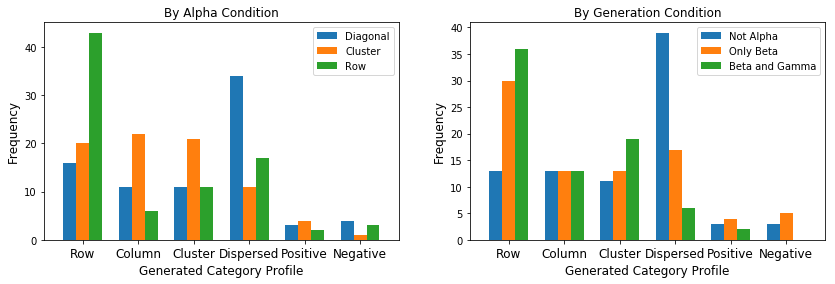

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
import random
import pickle
# execfile('Imports.py')
# import Modules.Funcs as funcs
%matplotlib inline

#pd.set_option('precision', 2)

grayscale=False

# import data
con = sqlite3.connect('../data/experiment.db')
info = pd.read_sql_query("SELECT condition,gentype,participant from participants", con)
df = pd.read_sql_query("SELECT * from generation", con)
alphas = pd.read_sql_query("SELECT * from alphas", con)
stimuli = pd.read_sql_query("SELECT * from stimuli", con).values

if grayscale:
    #Set colormap                                                                                                 
    csteps = 4
    palette = [[.8-float(rc)/csteps for rrc in range(3)] for rc in range(csteps)]
    plt.rc('image',cmap=palette)


data = {'condition':'','gentype':0}
gentypeStr = ['N','B','C'] #not alpha, only beta, beta-gamma
gentypeStrDisp = ['A\'','B','C'] #not alpha, only beta, beta

#info_new = info.copy()
info['gentypeStr'] = [gentypeStr[row.gentype] for i,row in info.iterrows()]
info['cond_comb'] = [row.condition+gentypeStr[row.gentype] for i,row in info.iterrows()]#info.copy().condition + info.copy().gentype.astype(str)

#eyeballed betagroups
betagroups = ['Row','Column','Cluster','Dispersed','Positive','Negative']
with open('individual_group_counts.p','rb') as f:
    data_pd = pickle.load(f)
# #Manual entry of eyeballed betagroup
# manual = dict(zip(betagroups,[[] for _ in range(len(betagroups))]))
# manual['Rows'] = [144,115,18,117,121,186,134,145,54,124,40,127,114,77,49,116,153,120,73,42,47,143,89,141,166,16,46,70]
# manual['Columns'] = [28,58,26,64,62,33,104,147,68,177,150,180,39,78,30,82,86,151,110,69,29,20,161,101,91]
# manual['Clusters'] = [55,95,59,87,148,97,23,169,149,103,185,99,93,123,19,106,85,126,25,81,74,100]
# manual['Dispersed'] = [57,172,75,108,112,72,140,158,184,139,160,154,138,79,21,98,136,43,56,181,61,178,135,163,48,60,22,132,173,36,80,50,159,182,96,71,119,65,131,165,90]
# total_len = 0
# manual_arr = []
# #Convert to array
# for group in manual.keys():
#     #Remove accidental duplicates
#     arr_list = list(np.unique(np.array(manual[group])))    
#     total_len += len(arr_list)
#     for arr_el in arr_list:
#         manual_arr += [[arr_el, group]]
        
#Merge into new dataframe
# manual_pd = pd.DataFrame(columns=('participant','betagroup'),data = manual_arr)
info_merge = pd.merge(info.copy(),data_pd,on='participant',how='left')

# print('Total n (Manual) = ' + str(total_len))
# print('Total n (Actual) = ' + str(len(info)))
# if total_len == len(info):
#     print('Cool, ns are equal.')
# else:
#     print('Looks like ns are not equal.')
#     #Check for where participants might not be assigned a betagroup
#     print([row['participant']  for i,row in info_merge.iterrows() if type(row['betagroup']) != str])

#Build histogram
plotnames = ['By Alpha Condition','By Generation Condition']#['Pooled','By Alpha Location','By Generation Type(NBC)', 'By Both']
conditions = [['condition'],['gentypeStr']]#[[], ['condition'],['gentypeStr'],['cond_comb']]
# cond_levels_all = [[None],['XOR','Cluster','Row'],gentypeStr,['XORN','XORB','XORC','ClusterN','ClusterB','ClusterC','RowN','RowB','RowC']]
cond_levels_all = [['XOR','Cluster','Row'],gentypeStr]
legends = [['Diagonal','Cluster','Row'],['Not Alpha','Only Beta','Beta and Gamma']]
# info_merge['betagroup','condition']
space = .3
fig,axs = plt.subplots(1,len(conditions),figsize=(14,4))#plt.subplots(2,2,figsize=(12,12))


for i,split in enumerate(plotnames):
    ax = axs.ravel()[i]
    groupcond = ['betagroup']+conditions[i]
    data_pd = info_merge.groupby(groupcond).participant.count()
    cond_levels = cond_levels_all[i]
#     if i>0:
#         cond_levels = list(np.unique(info_merge[conditions[i]]))
#     else:
#         cond_levels = [None]
    nlevels = len(cond_levels)
    xlim = range(1,len(betagroups)+1)
    for ci, cgrp in enumerate(cond_levels):
        width = (1 - space) / (len(cond_levels))
        bary = []
        for bi,bgrp in enumerate(betagroups):
            if cgrp is None: 
                bary += [data_pd[bgrp]]
            elif cgrp not in data_pd[bgrp].keys():
                bary += [0]
            else:
                bary += [data_pd[bgrp][cgrp]]                
        #barx = [j - (1 - space) / 2. + ci * width for j in range(1,len(betagroups)+1)]
#         if len(cond_levels) % 2 == 0:  #check if even
#             adj_units = len(cond_levels)
#             bar_mid_i = [np.floor((len(cond_levels))/2),np.ceil(len(cond_levefls)/2)-1]
#             bar_mid = ((xlim[int(bar_mid_i[0])] *width) + (xlim[int(bar_mid_i[1])] + width))/2 - width/2 
#         else:             #check if odd
#             bar_mid_i = [(len(cond_levels)+1)/2-1]
#             bar_mid = (xlim[bar_mid_i[0]] * width) - width/2 
        barx = [j - width*(len(cond_levels)-1)/2 + ci * width for j in xlim]
#         print(bary)
        if grayscale:
            ax.bar(barx,bary,width=width,color=palette[ci]) 
        else:
            ax.bar(barx,bary,width=width)
        if round((nlevels+1)/2.) == (ci+1):  
            xticks = barx

    ###Need to figure out hist heights
    #     if conditions[i] is None:
    #         data = list(info_merge.betagroup.as_matrix())
    #     else:
    #         data_raw = info_merge.groupby(conditions[i]).participant.count()
    #     data = list(info_merge.betagroup.as_matrix())
    ax.set_title(split)
    ax.set_xlim(min(xlim)-(1-space),max(xlim)+(1-space))
    ax.set_xlabel('Generated Category Profile',fontdict={'fontsize':12})
    ax.set_ylabel('Frequency',fontdict={'fontsize':12})
    #xlabstring = [''] * (len(betagroups) * 2)
    #xlabstring[1::1] = betagroups
    xlabstring = betagroups
    ax.set_xticks(xticks)
    ax.set_xticklabels(xlabstring,fontdict={'fontsize':12})
#     if i>0:
    ax.legend(legends[i],loc='upper right')

fig.savefig('eyeball_hist_flat.pdf', bbox_inches='tight', transparent=False)

In [34]:
info_merge

,condition,gentype,participant,gentypeStr,cond_comb,betagroup
0,Cluster,1,3,B,ClusterB,Row
1,Cluster,0,11,N,ClusterN,Cluster
2,Row,1,18,B,RowB,Cluster
3,XOR,2,37,C,XORC,Column
4,Row,1,39,B,RowB,Negative
5,XOR,1,95,B,XORB,Column
6,Row,1,125,B,RowB,Row
7,Cluster,2,126,C,ClusterC,Row
8,Cluster,0,127,N,ClusterN,Dispersed
9,Row,0,128,N,RowN,Dispersed


In [25]:
import numpy as np
import scipy.integrate as integrate
N = 100
t = .05
r = .707

v = N-1;
B01numr = (1.+(t**2.)/v)**-((v+1.)/2.);

def B01denmFunc(g):
    out = ((1.+N*g)**(-1./2.)) * ((1. + (t**2.)/((1.+N*g)*v))**-((v+1.)/2.)) * (r*(2.*np.pi)**(-1./2.)) * (g**(-3./2.)) * np.exp(-(r**2.)/(2.*g))
    return out

B01denm = integrate.quad(B01denmFunc,0,np.inf)
print B01numr
print B01denm
B01 = B01numr/B01denm[0];

print B01


0.998738186436
(0.11071564370033891, 6.0624767977238485e-09)
9.02075039314


In [14]:
a = range(6)
[[x,y] for i,x in enumerate(a) for j,y in enumerate(a) if j > i]

[[0, 1],
 [0, 2],
 [0, 3],
 [0, 4],
 [0, 5],
 [1, 2],
 [1, 3],
 [1, 4],
 [1, 5],
 [2, 3],
 [2, 4],
 [2, 5],
 [3, 4],
 [3, 5],
 [4, 5]]

In [8]:
from BF import BFtt
BFtt(100,-1)

5.565091267826707

In [18]:
import scipy.stats
scipy.stats.ttest_ind


<function scipy.stats.stats.ttest_ind>

[134, 82, 185, 159]


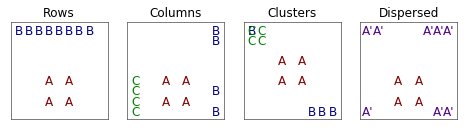

In [312]:
#Plot some samples
gentypeCols = [[.3,0,.5],[0,0,.5],[0,.5,0]]
pids = [random.choice(manual[grp]) for grp in betagroups]#[134,150,148,112]
print pids
fig,axs = plt.subplots(1,len(pids),figsize=(8,3))
for i,pid in enumerate(pids):
    ax = axs[i]
    info_p = info.loc[info.participant==pid]
    condition,gentype = info_p.condition.as_matrix()[0],info_p.gentype.as_matrix()[0]
    palphas = alphas[condition]
    pbetas = df.stimulus[df.participant == pid]
    titlestr = betagroups[i]
    if gentype==2:
        pdf = df.loc[df.participant==pid]
        betastr = [gentypeStrDisp[1] if pdf_row.category=='Beta' else gentypeStrDisp[2] for ii,\
pdf_row in pdf.iterrows() ]
        betacol = [gentypeCols[1] if pdf_row.category=='Beta' else gentypeCols[2] for ii,pdf_ro\
w in pdf.iterrows() ]
    else:
        betastr = gentypeStrDisp[gentype]
        betacol = gentypeCols[gentype]
    
    funcs.plotclasses(ax, stimuli, palphas, pbetas, betastr=betastr,betacol = betacol)
    ax.set_title(titlestr)

In [284]:
condition = info.loc[info.participant==pid].condition.as_matrix()[0]
print condition


Bottom


In [132]:
info_merge.groupby(['betagroup']+['condition']).participant.count()['Clusters']['Bottom']

12

In [44]:
plt.bar([0,1,2],[[1,2],[3,3],[0,3]])

Alpha     int64
Beta     object
dtype: object
   Alpha Beta
0      2    2
1      3    1
   Alpha Beta Gamma
0      2    2    hi
1      3    1   his
   Alpha Gamma Theta
0      2    hi   hi2
1      3   his  his1


In [186]:
    xlabstring = [''] * (len(betagroups) * 2)
    xlabstring[1::2] = betagroups
    print xlabstring

['', 'Rows', '', 'Columns', '', 'Clusters', '', 'Dispersed']


In [205]:
[j - (1 - space) / 2. + 1 * width for j in range(1,len(betagroups)+1)]

[0.7666666666666667,
 1.7666666666666666,
 2.7666666666666666,
 3.7666666666666666]

In [180]:
zip(betagroups,['' for _ in range(len(betagroups))])

[('Rows', ''), ('Columns', ''), ('Clusters', ''), ('Dispersed', '')]

In [196]:
[j - (1 - space) / 2. + 1 * width for j in range(1,len(betagroups)+1)]

0.11666666666666665

In [204]:
space, width

(0.3, 0.11666666666666665)

In [216]:
max([1,2,3,4])

4

In [245]:
bar_mid_i[0]

2.0

In [247]:
bar_mid

3.583333333333333

In [25]:
ti = np.unravel_index([3],(2,2))
aa = np.random.rand(2,2)
aa[ti]

array([0.56644788])

In [24]:
aa

array([[0.72447706, 0.85182965],
       [0.1402165 , 0.54666699]])